In [1]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2

print("TensorFlow version: ",tf.__version__)

2025-01-30 15:08:10.940460: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-30 15:08:10.940508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-30 15:08:10.942284: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-30 15:08:10.954189: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version:  2.15.0


In [2]:
!wget -q https://adversarial-ml-tutorial.org/introduction/pig.jpg
!wget -q https://raw.githubusercontent.com/USCDataScience/dl4j-kerasimport-examples/master/dl4j-import-example/data/imagenet_class_index.json

In [5]:
EPS = 2./255
IMAGENET_LABELS = "imagenet_class_index.json"

with open(IMAGENET_LABELS) as f:
    IMAGENET_CLASSES = {int(i):x[1] for i,x in json.load(f).items()}

In [6]:
# Function to load up an image from a local filepath and
# display it
def show_image(image_path):
    image_pixels = plt.imread(image_path)
    plt.imshow(image_pixels)
    plt.show()
    return image_pixels

# Function to preprocess an image for performing inference
def preprocess_image(image_pixels, preprocess=False):
    if preprocess:
        image_pixels = preprocess_input(image_pixels)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)

    return image_pixels

# Clipping utility to project delta back to our favorable pixel
# range ([0 ,1])
def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, 
                            clip_value_min=-EPS, 
                            clip_value_max=EPS)

# Parse the label
def get_label(preds):
    print(IMAGENET_CLASSES[preds.argmax()])

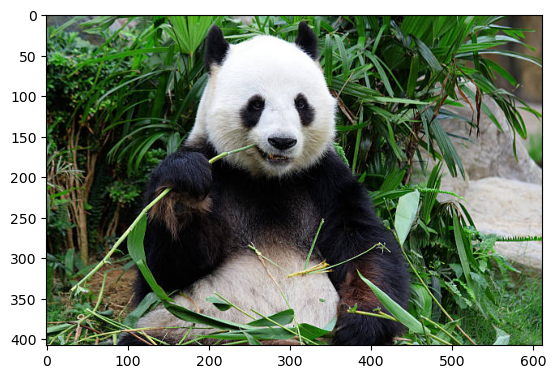

In [12]:
sample_image = show_image("./data/imagenet/giant_panda/giantpanda.jpg")
preprocessed_image = preprocess_image(sample_image, preprocess=True)
resnet50 = tf.keras.applications.ResNet50(weights="imagenet")

In [13]:
preds = resnet50.predict(preprocessed_image)
print("Predicted:", decode_predictions(preds, top=3)[0])
print("Class idx:", preds.argmax())

1/1 [==============================] - 1s 942ms/step
Predicted: [('n02510455', 'giant_panda', 0.99872273), ('n02509815', 'lesser_panda', 0.0005726167), ('n02488702', 'colobus', 0.0002929433)]
Class idx: 388


In [15]:
def generate_adversaries_targeted(image_tensor, delta, model,
    true_index, target_index, optimizer):
    # Loss function
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    
    for t in range(350):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = preprocess_input(image_tensor + delta)
            predictions = model(inp, training=False)
            loss = (- scc_loss(tf.convert_to_tensor([true_index]), predictions) + 
	                    scc_loss(tf.convert_to_tensor([target_index]), predictions)) 
            if t % 20 == 0:
                print(t, loss.numpy())
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Project the delta back (l-infinite norm)
        delta.assign_add(clip_eps(delta))

    return delta

def perturb_image(image_path, true, target, model, optimizer):
    # Load and preprocess image but a but without any `preprocess_input`
    sample_image = show_image(image_path)
    preprocessed_image = preprocess_image(sample_image)

    # Generate predictions before any adversaries
    unsafe_preds = model.predict(preprocess_input(preprocessed_image))
    print("Prediction before adv.:", decode_predictions(unsafe_preds, top=3)[0])

    # Initialize the perturbation quantity
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the learned delta and display it
    delta_tensor = generate_adversaries_targeted(image_tensor, delta, model, 
                                                 true, target, optimizer)
    plt.imshow(50*delta_tensor.numpy().squeeze()+0.5)
    plt.show()

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = preprocess_input(image_tensor + delta_tensor)
    preds = model.predict(perturbed_image)
    print("Prediction after adv.:", decode_predictions(preds, top=3)[0])

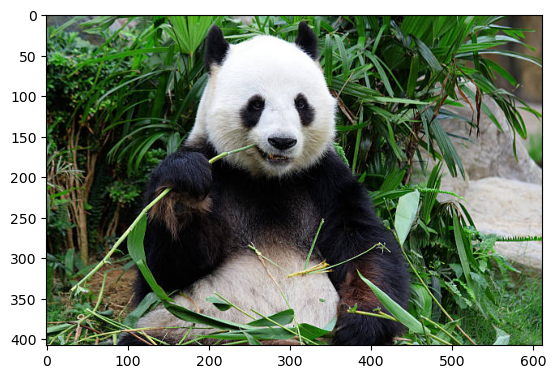

1/1 [==============================] - 0s 39ms/step
Prediction before adv.: [('n02510455', 'giant_panda', 0.9986791), ('n02509815', 'lesser_panda', 0.0005822608), ('n02488702', 'colobus', 0.00031490155)]
0 15.293932
20 10.048318
40 6.394062
60 3.6499689
80 1.6415277
100 0.09884381
120 -1.192522
140 -2.2811112
160 -3.315899
180 -4.2965508
200 -5.3314877
220 -6.4821997
240 -7.594819
260 -8.713163
280 -9.798784
300 -10.902081
320 -11.995143
340 -13.184086


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


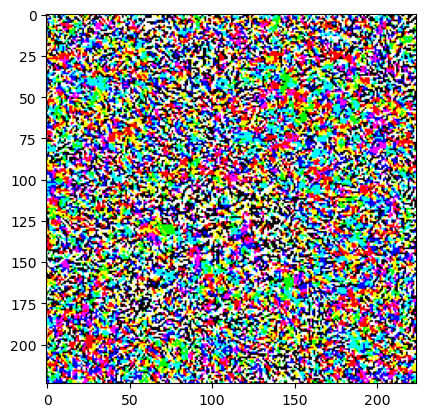

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


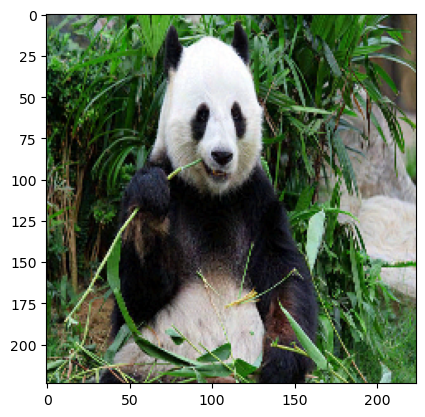

1/1 [==============================] - 0s 41ms/step
Prediction after adv.: [('n02113023', 'Pembroke', 0.77525574), ('n02113186', 'Cardigan', 0.12670459), ('n02108000', 'EntleBucher', 0.02582429)]


In [18]:
#@title Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
perturb_image("./data/imagenet/giant_panda/giantpanda.jpg", 388, 263, resnet50, optimizer)